# $\ell^2$-regularized Logistic Regression

In this tutorial section, we demonstrate an $\ell^2$-regularized logistic regression example using SketchyOpts. We first introduce some useful notations. 
<!-- - $X \in \mathbb{R}^{n \times p}$: input features (or design matrix)
- $y \in \{-1, +1\}^{n}$: target classes
- $(x_i, y_i) \in \mathbb{R}^p \times \{-1, +1\}$: $i$<sup>th</sup> training sample
- $\beta = [\beta_0, \beta_{1}^{\mathsf{T}}] \in \mathbb{R}^{p+1}$: parameters of the model (including both the weights $\beta_1$ and bias $\beta_0$)
- $\lambda \geqslant 0$: regularization strength of the model -->
| Symbol | Description |
| --- | --- |
| $X \in \mathbb{R}^{n \times p}$ | input features (or design matrix) |
| $y \in \{-1, +1\}^{n}$ | target classes |
| $(x_i, y_i) \in \mathbb{R}^p \times \{-1, +1\}$ | $i$<sup>th</sup> training sample |
| $\beta = [\beta_0, \beta_{1}^{\mathsf{T}}] \in \mathbb{R}^{p+1}$ | parameters of the model (including both the weights $\beta_1$ and bias $\beta_0$) |
| $\lambda \geqslant 0$ | regularization strength of the model |

Logistic regression is a discriminative classification model that seeks to represent posterior probabilities of $K$ classes using linear functions of the input features. In this example, we focus on the binary case in which $K = 2$. The model has the form
$$
    \log \frac{p(y = +1 \mid x)}{p(y = -1 \mid x)} = \beta_0 + \beta_1^{\mathsf{T}} x
$$

The above log-odd and the constrain that the probabilities sum to one together suggest the probability of each label is computed as
$$
\begin{aligned}
    & p(y = -1 \mid x) = \frac{1}{1 + \exp(\beta_0 + \beta_1^{\mathsf{T}} x)} \\
    & p(y = +1 \mid x) = \frac{\exp(\beta_0 + \beta_1^{\mathsf{T}} x)}{1 + \exp(\beta_0 + \beta_1^{\mathsf{T}} x)}
\end{aligned}
$$
which can also be compactly written using sigmoid function $\sigma(x) = e^{x} / (1 + e^{x})$ as $\sigma\big(y \cdot (\beta_0 + \beta_1^{\mathsf{T}} x)\big)$. 

To estimate the parameters of the logistic regression model, we usually use maximum likelihood estimation. Using negative log-likelihood, we pose the $\ell^2$-regularized logistic regression as the following optimization problem
$$
    \underset{\beta}{\operatorname{minimize}} ~ \frac{1}{n} \sum_{i=1}^{n} \log \Big(1 + \exp\big(-y_i (\beta_0 + \beta_1^{\mathsf{T}} x_i)\big)\Big) + \frac{\lambda}{2} \lVert \beta_1 \rVert_2^2
$$
The additional regularization term introduces bias to the model with the hope to decrease the variance and temper overfitting (note that only the weights $\beta_1$ get penalized). The regularization strength $\lambda$ is often chosen via cross-validation to ensure the fitted model generalizes well to the unseen (test) data. 

## Dataset

In this example, we use the `real-sim` dataset from the [LIBSVM data collection](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html) {cite}`lr-chang2011libsvm`. The dataset was originally gathered by [Andrew McCallum](https://people.cs.umass.edu/~mccallum/data.html) as a part of a larger collection of UseNet discussion group articles. The dataset has 72,309 samples and each sample has 20,958 features. We obtain the dataset from [OpenML](https://www.openml.org/d/1578) and use a random 80/20 split to construct training and test subsets. 

Given that the dataset is a document set, a common pre-processing practice in text classification is normalizing each sample to unit length. Fortunately, the dataset comes pre-processed. Moreover, the labels are already $\pm 1$-encoded. We thus simply add a constant 1 column to the data matrix to incoporate the bias. 

```{note}
The data matrix in this example is sparse. Instead of densifying it, we take advantage of the experimental [JAX sparse module](https://jax.readthedocs.io/en/latest/jax.experimental.sparse.html). To enable sparsification of the PROMISE solver, one needs to set argument ``sparse = True``{l=python} when initializing the solver. Moreover, any function that gets passed into the solver (*e.g.* objective function ``fun`` etc.) needs also be compatible with sparse data input. 
```

```{caution}
Since the JAX sparse module is currently under development, the sparsification feature of SketchyOpts is preliminary and might not be performant. We plan to gradually improve its performance once the support for sparse matrix operations in JAX is finalized and becomes official.  
```

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import scipy as sp
import numpy as np

# set seed for reproducibility
seed = 0
rng = np.random.default_rng(seed)

# download dataset
X, y = fetch_openml(data_id=1578, return_X_y=True)

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)
n_train = X_train.shape[0]
n_test = X_test.shape[0]
p = 1 + X.shape[1] # include bias

# incorporate bias into the data (prefix a constant 1 column)
X_train = sp.sparse.hstack([np.ones((n_train,1)), X_train])
X_test = sp.sparse.hstack([np.ones((n_test,1)), X_test])

## Fitting the model

We first define the objective function of the optimization problem introduced earlier. We also implement a callback function that gets called to help us keep track of the loss and misclassification rates before each update of the parameters in the optimization loop. 

In [2]:
import jax.numpy as jnp
import jax
from jax.experimental import sparse

# define objective evaluation function
@sparse.sparsify
def compute_objective(params, X, y, reg): 
    return jnp.mean(jnp.log(1 + jnp.exp(sparse.todense(-y * (X @ params))))) + (reg / 2) * jnp.dot(params[1:], params[1:])

@sparse.sparsify
def fun(params, data, reg): 
    # slice data array to get features and classes
    X = data[:, :-1]
    y = data[:, -1]
    
    # compute objective
    obj = compute_objective(params, X, y, reg)
    
    return obj

# define function that computes the error rate
@jax.jit
def compute_error_rate(params, X, y): 
    scores = X @ params
    return jnp.mean(y != jnp.where(scores >= 0, 1, -1))

# initialize empty containers
train_loss = []
train_error = []
test_error = []

# define the callback function
eval_freq = 5
def callback(params, state, data, reg): 
    # perform computations every 5 iterations
    if state.iter_num % eval_freq == 0: 
        # record training loss
        train_loss.append(jax.jit(compute_objective)(params, sparse.BCOO.from_scipy_sparse(X_train), y_train, reg))

        # evaluate both training and test errors
        train_error.append(compute_error_rate(params, sparse.BCOO.from_scipy_sparse(X_train), y_train))
        test_error.append(compute_error_rate(params, sparse.BCOO.from_scipy_sparse(X_test), y_test))
    
    return params, state

We use SketchyKatyusha (with the Nyström subsampled Newton preconditioner) to fit the model. Rank and regularization for the preconditioner are set to their default values ($10$ and $10^{-3}$ respectively). Since the objective has a non-constant Hessian, we set the preconditioner update frequency to the recommended $\lceil n/b_g \rceil$ (where $b_g$ is the stochastic gradient batch size) so that the preconditioner is computed after each equivalent full pass of the training set. The rest of the hyperparameters also follow the recommended values discussed in the PROMISE paper {cite}`lr-frangella2024promise`. In this example, we arbitrarily set the regularization strength $\lambda = 0.01/n$ to demonstrate the performance of SketchyKatyusha as this small value is not likely to meaningfully improve the conditioning of the problem which makes it more challenging for the optimizer. 

In [3]:
from sketchyopts.solver import SketchyKatyusha

# specify hyperparameters
grad_batch_size = 512
hess_batch_size = int(np.floor(np.sqrt(n_train)))
update_freq = int(np.ceil(n_train / grad_batch_size))
snapshop_update_prob = grad_batch_size / n_train
maxiter = 500
tol = 1e-6

init_params = jnp.zeros(p)
data = sp.sparse.hstack([X_train, y_train.reshape(-1,1)])
reg = 0.01 / n_train

# initialize the solver and start the optimization
opt = SketchyKatyusha(fun=fun, 
                      pre_update=callback, 
                      grad_batch_size=grad_batch_size, 
                      hess_batch_size=hess_batch_size, 
                      update_freq=update_freq, 
                      snapshop_update_prob=snapshop_update_prob,
                      mu=reg,
                      seed=seed, 
                      maxiter=maxiter, 
                      tol=tol, 
                      jit=True,
                      sparse=True)

params, state = opt.run(init_params, sparse.BCOO.from_scipy_sparse(data), reg)

We plot suboptimality gaps and misclassification rates from the run. The optimal solution is obtained by running L-BFGS {cite}`lr-liu1989on` with [scikit-learn API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

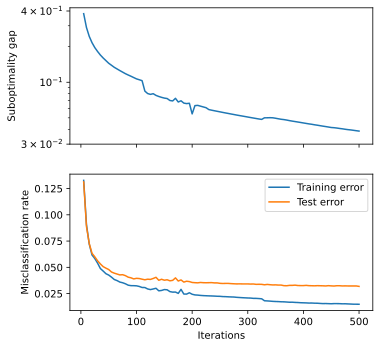

In [4]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# obtain the optimal solution
clf = LogisticRegression(C=1.0 / (reg * n_train), fit_intercept=True, tol=tol, solver='lbfgs', max_iter=250)
clf.fit(X_train.tocsr()[:,1:], y_train)
opt_val = compute_objective(np.concatenate([clf.intercept_, clf.coef_.reshape(-1)]), sparse.BCOO.from_scipy_sparse(X_train), y_train, reg)

# update plot settings
%config InlineBackend.figure_formats = ['svg']
plt.rcParams.update({'font.size': 10})

# manually evaluate the resulting parameters
# as the callback only gets called before each update
train_loss.append(compute_objective(params, sparse.BCOO.from_scipy_sparse(X_train), y_train, reg))
train_error.append(compute_error_rate(params, sparse.BCOO.from_scipy_sparse(X_train), y_train))
test_error.append(compute_error_rate(params, sparse.BCOO.from_scipy_sparse(X_test), y_test))

# compute suboptimality gap
subopt_gap = np.array(train_loss) - opt_val

# make subplots
fig, axes = plt.subplots(2, sharex=True, subplot_kw=dict(box_aspect=0.45))
plt.tight_layout(h_pad=2)

# plot suboptimality gap
iter_nums = np.arange(eval_freq, maxiter+1, eval_freq)
axes[0].semilogy(iter_nums, subopt_gap[1:])
axes[0].set_ylabel('Suboptimality gap')

# plot training and test errors
axes[1].plot(iter_nums, train_error[1:], label='Training error')
axes[1].plot(iter_nums, test_error[1:], label='Test error')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Misclassification rate')
axes[1].legend()

plt.show()

The objective suboptimality for SketchyKatyusha appears to have decreased at a linear rate. We note that running the solver for 500 iterations is equivalent to going through the entire training set for less than 5 epochs; based on the experiment results from the PROMISE paper {cite}`lr-frangella2024promise`, with extra optimization time budget, the gap would eventually reach machine precision. 

## Remarks

Lastly, we would like to demonstrate the performance gain from enabling JIT-compilation. For demonstration purpose, we bring down the number of training samples to 640 and run the solver for 10 iterations on CPU. Although the problem scale is dramatically reduced from our running example, we expect the pattern to persist, if not magnify with more training samples, extended number of iterations, or on accelerated computing instances. For this reason, we recommend running PROMISE solvers with ``jit = True``{l=python} (which is the default setting) whenever possible. 

In [5]:
# specify demo parameters
demo_num_samples = 640
demo_grad_batch_size = 128
demo_hess_batch_size = 32
demo_update_freq = 5
demo_snapshop_update_prob = 0.2
demo_maxiter = 10
demo_reg = 0.01 / demo_num_samples

# subsample the original training data
demo_data = sparse.BCOO.from_scipy_sparse(data.tocsr()[:demo_num_samples,:])

# initialize JIT-enabled solver
opt_jitted = SketchyKatyusha(fun=fun, 
                      grad_batch_size=demo_grad_batch_size, 
                      hess_batch_size=demo_hess_batch_size, 
                      update_freq=demo_update_freq, 
                      snapshop_update_prob=demo_snapshop_update_prob,
                      mu=demo_reg,
                      seed=seed, 
                      maxiter=demo_maxiter, 
                      tol=tol, 
                      jit=True,
                      sparse=True)

# initialize JIT-disabled solver
opt_non_jitted = SketchyKatyusha(fun=fun, 
                      grad_batch_size=demo_grad_batch_size, 
                      hess_batch_size=demo_hess_batch_size, 
                      update_freq=demo_update_freq, 
                      snapshop_update_prob=demo_snapshop_update_prob,
                      mu=demo_reg,
                      seed=seed, 
                      maxiter=demo_maxiter, 
                      tol=tol,
                      jit=False,
                      sparse=True)

print("JIT-enabled solver:")
%timeit _ = opt_jitted.run(init_params, demo_data, demo_reg)

print("JIT-disabled solver:")
%timeit _ = opt_non_jitted.run(init_params, demo_data, demo_reg)

JIT-enabled solver:
14.8 s ± 175 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
JIT-disabled solver:
26.8 s ± 178 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## References

```{bibliography}
:labelprefix: LR
:keyprefix: lr-
```